In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=bbc5ece6e9f169deee5a2757e9d3eb9ce42aede2f8c9a69e9e39fa61107d9d2f
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [9]:
sc = SparkContext("local", "KMeans")
sqlContext = SQLContext(sc)

ValueError: ignored

In [17]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
# Load the data from the csv file
data = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('players_22_pca.csv')

# Select the columns you want to use for clustering
feature_cols = ['{}'.format(i) for i in range(30)]
data = data.select(*feature_cols)

# Create a vector assembler object to combine all the feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembler_data = assembler.transform(data)

# Determine the suitable number of clusters
wcss = []
for k in range(2, 11):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(assembler_data)
    wcss.append(model.summary.trainingCost)

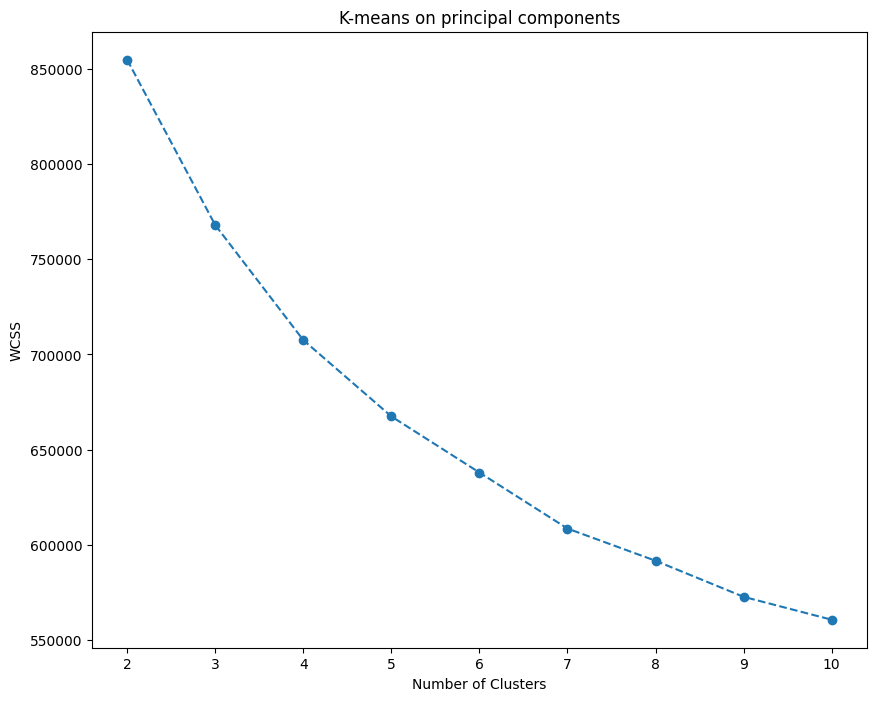

In [20]:
plt.figure(figsize=(10,8))
plt.plot(range(2,11),wcss,marker='o',linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("K-means on principal components")
plt.show()

In [14]:


# Convert the DataFrame to an RDD of numpy arrays
parsedData = data.rdd.map(lambda row: array([row[i] for i in range(30)]))

# Initialize two centroids
centroids = [array([0.0 for i in range(30)]), array([3.0 for i in range(30)])]

# Function to compute the closest centroid for a data point
def closestCentroid(point):
    bestIndex = 0
    closest = float("+inf")
    for i in range(len(centroids)):
        tempDist = sqrt(sum([x**2 for x in (point-centroids[i])]))
        if tempDist < closest:
            closest = tempDist
            bestIndex = i
    return (bestIndex, (point, 1))

# Function to compute the new centroid
def computeNewCentroid(data):
    newCentroid = data[1][0]/data[1][1]
    return (data[0], newCentroid)

for i in range(10):
    # Assign each data point to the closest centroid
    closest = parsedData.map(closestCentroid)
    
    # Compute the new centroids by averaging the data points assigned to each centroid
    newCentroids = closest.reduceByKey(lambda x,y : (x[0]+y[0], x[1]+y[1])).map(computeNewCentroid).collect()
    
    # Update the centroids
    for newCentroid in newCentroids:
        centroids[newCentroid[0]] = newCentroid[1]

print("Final centroids: " + str(centroids))


Final centroids: [array([-2.77044194e+00,  8.47682122e-03,  3.56682907e-01, -6.38525191e-03,
        1.06295141e-01,  3.06339188e-02,  4.57690633e-02,  3.12416698e-02,
        2.43113128e-02, -6.10797339e-03, -2.04781226e-02, -8.29808994e-03,
       -7.78498411e-03, -7.13781368e-03, -1.07078769e-02,  2.70689296e-03,
       -6.01886228e-03,  1.37462738e-02, -3.55070066e-02,  3.44959579e-02,
        1.17616728e-02,  7.45186616e-03,  4.13831984e-02, -3.90277896e-02,
        8.29667290e-03,  4.91091615e-03,  8.41097916e-03,  5.76013187e-03,
       -4.46628554e-03, -5.87752155e-03]), array([ 4.05973348e+00, -1.24217131e-02, -5.22673845e-01,  9.35678188e-03,
       -1.55762132e-01, -4.48901469e-02, -6.70687936e-02, -4.57807295e-02,
       -3.56251648e-02,  8.95046517e-03,  3.00081076e-02,  1.21598049e-02,
        1.14079130e-02,  1.04595663e-02,  1.56910440e-02, -3.96661045e-03,
        8.81988406e-03, -2.01434317e-02,  5.20310429e-02, -5.05494784e-02,
       -1.72352490e-02, -1.09197706e-02

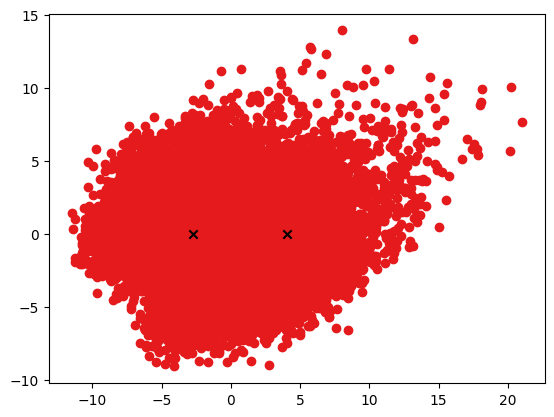

In [13]:
import matplotlib.pyplot as plt

# Assign each data point to the closest centroid
closest = parsedData.map(closestCentroid)

# Collect the data points and their assigned centroid
clustered_data = closest.collect()

# Extract the cluster labels and data points
labels = [x[0] for x in clustered_data]
points = [x[1][0] for x in clustered_data]

# Convert the centroids to a list of lists
centroid_list = [centroid.tolist() for centroid in centroids]

# Plot the data points with colored regions according to the centroid they belong to
for i in range(len(centroid_list)):
    cluster_points = [points[j] for j in range(len(points)) if labels[j] == i]
    plt.scatter([p[0] for p in cluster_points], [p[1] for p in cluster_points], color=plt.cm.Set1(i/10.))
    plt.scatter(centroid_list[i][0], centroid_list[i][1], marker='x', color='k')
plt.show()
